<a href="https://colab.research.google.com/github/mgonzal1/nma_wombat_connectivy_project/blob/polynomial/connectivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import ipywidgets as widgets 
import numpy as np
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)



alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [16]:
#@title Representative session
#@markdown As first step, lets choose 1 session to start trainning the model. Let's see which session has more neurons in the areas that we are going to use and how many neurons it has.
@widgets.interact
def get_representative_session(min_areas=(0,7)):
  """ To simplify the model we are selecting a session recording with most of the regions represented.
    This interactive function help us to decide the session based on the minimal regions represented and number of 
    total neurons recorded.

  """
  print("")
  brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                  ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                  ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                  ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                  ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                  ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                  ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                  ]
  regions = ["visual ctx", "thal", "hipp", "non-visual ctx", "midbrain", "basal ganglia", "cortical subplate"]
  for i in range (0,38):
    session = alldat[i]
    brain_areas = set(session['brain_area'])
    representative = []
    for group in brain_groups:
        representative.append(any(area in brain_areas for area in group))
    
    if(representative.count(True)>min_areas):
      print("Session:" , i, "Total neurons:",session['brain_area'].shape[0])
      #labels, sizes = np.unique(session['brain_area'], return_counts=True)
      #fig = plt.figure()
      #ax = fig.add_axes([0,0,1,1])
      #ax.bar(regions,representative)
      #ax.set_title("Session {}".format(i))
      #plt.show()


interactive(children=(IntSlider(value=3, description='min_areas', max=7), Output()), _dom_classes=('widget-int…

In [ ]:
# SET DEFAULTS
trial_time = 2.5
session=12
n_sessions = len(alldat)
data_set = alldat[session]

In [ ]:
#@title General functions to get data
def get_trainning_set():
  """
  Get a subset of alldat for trainning purposes.

  Returns:
    map: dat['spks']: neurons by trials by time bins. Time bin = 10ms.
         dat['brain_area']: brain area for each neuron recorded.
         dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
         dat['contrast_left']: contrast level for left stimulus.
         dat['response']: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
         dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and always does!).
  """
  # Functions to split data and get a subset. If condition of areas  
  tranning_set = alldat
  return trainning_set

def get_validation_set():
  """
  Get a subset of alldat for validation purposes. This should be ~5%-10% of all the data.

  Returns:
    map: dat['spks']: neurons by trials by time bins. Time bin = 10ms.
         dat['brain_area']: brain area for each neuron recorded.
         dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
         dat['contrast_left']: contrast level for left stimulus.
         dat['response']: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
         dat['response_times']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and always does!).
  """
  # Functions to split data and get a subset 
  validation_set = alldat
  return validation_set

def get_spks_from_area(dat,brain_area):
  n_neurons = dat['spks'].shape[0]
  index_neurons = np.zeros(n_neurons,dtype=bool)

  for neuron in range(n_neurons):
    index_neurons[neuron] = dat['brain_area'][neuron] in brain_area

  area_data = (dat['spks'][index_neurons,:,:].sum(axis=2)/trial_time).T
  return area_data, index_neurons

def get_visual_ctx(data_set):
  # TODO: Change to the corrrect areas
  visual_ctx = ["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"]
  visual_data, _ = get_spks_from_area(data_set, visual_ctx)
  return visual_data

def get_motor_ctx(data_set):
  #TODO : Change to the correct areas
  motor_ctx = ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"]
  motor_data, _ = get_spks_from_area(data_set, motor_ctx)
  return motor_data

def get_stimulus(data_set):
  """
   Args: 
      data_set: (map) Subset of alldat
      
   Returns:
      stims[nTrials x 3]  bias: constant with ones
                          stim_left: contrast level for the right stimulus.
                          stim_right: contrast level for left stimulus.
  """


  stims = data_set['contrast_left'], data_set['contrast_right']
  stims = np.array(stims).T
  n_trials = stims.shape[0]
  stims = np.column_stack((np.ones(n_trials),stims))
  return stims

def get_response(data_set):
  """
   Args: 
      data_set: Subset of alldat

   Returns:
        np.array: which side the response was (-1, 0, 1). Choices for the right stimulus are -1.
  """
  response =  np.array(data_set['response'])
  return response

def get_binary_response(data_set):
  """
   To simplify the model we ares going to use a binary response instead of the 3 possible values: left, no-action, right
   to true or false comparing the stimulus to the expected actions. 

   Args: 
      data_set: Subset of alldat

   Returns:
        binary (np.array boolean) : Returns True or False
  """
  visual_stims = get_stimulus(data_set)
  vis_left, vis_right = [visual_stims[:,1], visual_stims[:,2]]
  response = get_response(data_set)
  binary_response = np.sign(response)==np.sign(vis_left-vis_right)
  return binary_response

# MODEL1:  Encodig from visual stimulus

Using Multiple order X polynomial regresion with OLS (Ordinary Least square estimator)

Testing with k-fold cross-validation

**Parameters:**
*   visual stimulus : [nTrials x 2] Contrast on lefth and right
*   visual trials matrix : [nTrials x Neurons]

**Steps:**
*   Model Fit

**TODO List**
*   Do the polinomyal_regression function
*   Get the Order of the polinomyal regression
*   Test with more sessions, the MSE decrease?


stimuls shape (300, 3)
visual_dat shape (300, 34)
MSE 3.9932810695570886


<BarContainer object of 34 artists>

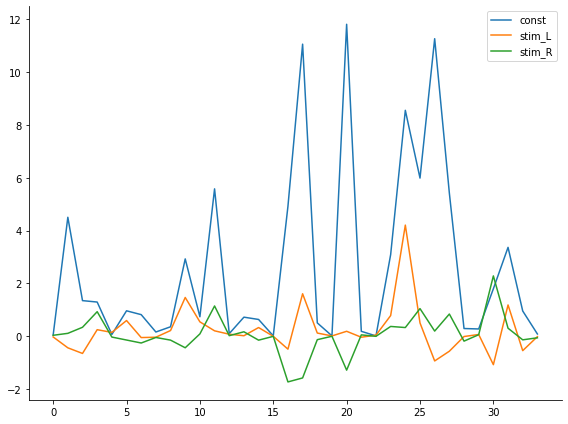

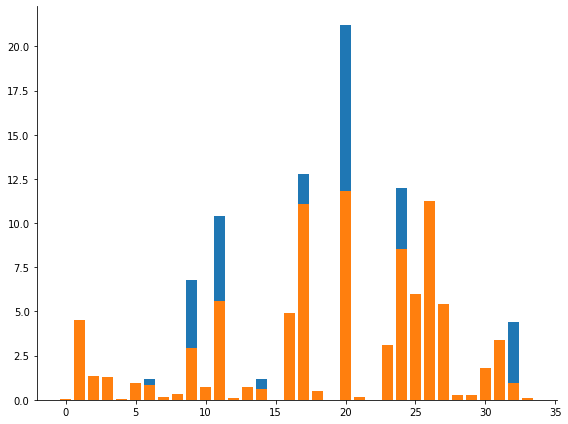

In [ ]:
#@title DRAFT OF V1 MODEL


visual_dat = get_visual_ctx(data_set)
stim = get_stimulus(data_set)

print(f'stimuls shape {stim.shape}')
print(f'visual_dat shape {visual_dat.shape}')

model = LinearRegression(fit_intercept=False).fit(stim, visual_dat) 
A1 = model.coef_.T
visual_dat_hat = stim @ A1 
mse = np.mean( (visual_dat-visual_dat_hat)**2 )
print(f'MSE {mse}')

## TODO : ADD MSE
#mse = cross_val... (model, X,y, cv=8, )
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(model.coef_)
plt.legend(['const','stim_L', 'stim_R'])

fig,ax = plt.subplots(figsize=(8,6))
tr=4
ax.bar(range(34),visual_dat[tr,:])
ax.bar(range(34),visual_dat_hat[tr,:])


In [49]:
#MSE for multiple features for Ordinary least squares estimator for linear regression.(MULTIPLE LINEAR REGRESSION)

def ordinary_least_squares(X,y):
  theta_hat = np.linalg.inv(stim.T @ stim) @ stim.T @ visual_dat
  return theta_hat
  
theta_hat = ordinary_least_squares(stim, visual_dat)
#print(theta_hat)
#visual_dat_hat = stim @ theta_hat 


def design_matrix(x, order):
  design_matrix = []
  if x.ndim == 1:
    x = x[:, None]
  # Loop through rest of degrees and stack columns
  design_matrix = np.ones((x.shape[0], 1)) 
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, np.power( x, degree)))
  # Shape 300 x 1
  return design_matrix

max_order = 3

def polynomial_reggression(x,y,max_order):
  theta_hats = {}
  for order in range(max_order + 1):

    X_design = design_matrix(stim, order)
    this_theta = ordinary_least_squares(X_design, y)
    theta_hats[order] = this_theta
  #Shape 3 x 34
  return theta_hats

theta_hats = polynomial_reggression(stim, visual_dat, max_order)



In [47]:
print(stim**2)
print("POWER")
print(np.power(stim,2))

[[1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.25   0.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.25   0.    ]
 [1.     0.0625 1.    ]
 [1.     0.25   0.    ]
 [1.     0.25   0.0625]
 [1.     0.     1.    ]
 [1.     0.     0.0625]
 [1.     0.25   0.0625]
 [1.     0.0625 0.25  ]
 [1.     1.     0.0625]
 [1.     1.     0.    ]
 [1.     0.     0.25  ]
 [1.     0.0625 1.    ]
 [1.     0.     1.    ]
 [1.     1.     0.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.25   1.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.0625 1.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     0.     0.    ]
 [1.     1.     0.    ]
 [1.     0.     0.    ]
 [1.     0.25   0.    ]
 [1.     0.     1.    ]
 [1.     0.     0.25  ]
 [1.     0.25   0.    ]
 [1.     1.     0.0625]
 [1.     1.     1.    ]
 [1.     0.     0.    ]
 [1.     1.     0.0625]
 [1.     0.     0.    ]
 [1.     1.     0.25  ]
 [1.     0.0625 

In [45]:
def eval_polynomial():
  mse = np.zeros((max_order + 1))
  for order in range(0, max_order + 1):
     X_design = design_matrix(stim, order)
     print(theta_hats[order].shape, X_design.shape)
     visual_dat_hat = X_design @ theta_hats[order]
     residuals = visual_dat - visual_dat_hat
     mse[order] = np.mean(residuals ** 2)
  return mse

order_mse = eval_polynomial()
print(order_mse)

(3, 34) (300, 1)


ValueError: ignored

# MODEL3:  Decoding from motor
Logistic Regression no penalty

**Parameters:**
*   Motor matrix [nTrials x neurons].
*   Reponses 3 categories.

**TODO List**
*   Change to get 3 categories of response (Left, Right, None).
*   Filter trials to use only trials that succed to perform the action.


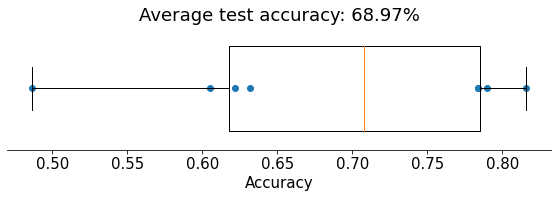

In [ ]:
# obtenemos matrices 'y' y 'x'
motor_dat = get_motor_ctx(data_set)
binary_dat = get_binary_response(data_set)

#definimos el modelo & ajustamos los datos
log_reg = LogisticRegression(penalty="none")
log_reg.fit(motor_dat, binary_dat) 

# predicciones
binary_dat_hat = log_reg.predict(motor_dat)

#accuracy
similarity = (binary_dat == binary_dat_hat)   #nos da booleans de [true false] de predicciones correctas
accuracy = np.sum(similarity)/len(binary_dat)

#crossvalidation 
accuracies = cross_val_score(LogisticRegression(penalty='none'), motor_dat, binary_dat, cv=8)

f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)